# Preprocessing and Feature Creation

Data Processing and Feature Engineering is performed in the following, using the given variables downloaded from the Binance API, we will calculate the following:

In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=ea9a56c967e793b91db2df84685fdc738fabf75f9f2e62a103d97c2d15735853
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [23]:
# Collecting Cryptocurrency Informations
import torch
from ta.momentum import rsi
from ta.trend import macd
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from ta import add_all_ta_features
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import EMAIndicator, MACD
from ta.volume import VolumeWeightedAveragePrice

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 2018-12-31: ADAUSDT, BNBUSDT, BTCUSDT, ETCUSDT, ETHUSDT, LTCUSDT, TRXUSDT, USDCUSDT, VETUSDT, XLMUSDT, XRPUSDT
# Vijha et al. 2020

directory = '/kaggle/input/crypto-1-hour-2018-12-31'

# Initialize an empty list to store DataFrames
dataframes = []

for filename in os.listdir(directory):
    if filename.endswith('.csv') and filename != "USDCUSDT1h.csv":
        ticker = filename[:-6] # Remove the '1h.csv' extension
        data = pd.read_csv(os.path.join(directory, filename), parse_dates=['time'])

        # Feature Engineering
        # df['average'] = (df['high'] + df['low'] + df['close'])/3
        # df["DailyLogReturn"] = np.log(1 + df["close"].pct_change())
        # df['price_return'] = (df['close'] - df['open']) / df['open']
        # df["NormClose"] = (df["close"] - df["close"].mean()) / df["close"].std()
        # df["ALR1W"] = df["DailyLogReturn"].rolling(window=5).sum() * 5
        # df["ALR2W"] = df["DailyLogReturn"].rolling(window=10).sum() * 5
        # df["ALR1M"] = df["DailyLogReturn"].rolling(window=21).sum() * 21
        # df["ALR2M"] = df["DailyLogReturn"].rolling(window=42).sum() * 21
        # df['Day of Week'] = df['time'].dt.dayofweek
        # df["RSI"] = rsi(df["close"]) / 100
        # df["MACD"] = macd(df["close"])
        # df['buy_volume_ratio'] = df['buy_base_vol'] / df['volume']
        # df['Ticker'] = ticker

        windows = [5, 10, 20]
        data["DailyLogReturn"] = np.log(1 + data["close"].pct_change())

        data['volume_quote_ratio'] = data['volume'] / data['quote_volume']
        data['buy_sell_volume_ratio'] = data['buy_base_vol'] / data['volume']
        data['buy_sell_quote_ratio'] = data['buy_quote_vol'] / data['quote_volume']

        # Stochastic Oscillator
        stoch = StochasticOscillator(high = data['high'], low = data['low'], close = data['close'])
        data['stoch_k'] = stoch.stoch()
        data['stoch_d'] = stoch.stoch_signal()

        # VWAP
        vwap = VolumeWeightedAveragePrice(high = data['high'], low = data['low'],
                                         close = data['close'], volume = data['volume'])
        data['vwap'] = vwap.volume_weighted_average_price()

        for window in windows:
            # Parkinson Volatility
            data[f'parkinson_vol_{window}'] = np.sqrt(
                (1.0 / (4.0 * np.log(2.0))) *
                (np.log(data['high'] / data['low']) ** 2).rolling(window).mean()
            )

            # Garman-Klass Volatility
            data[f'garman_klass_vol_{window}'] = np.sqrt(
                (0.5 * np.log(data['high'] / data['low']) ** 2) -
                (2.0 * np.log(2.0) - 1.0) * (np.log(data['close'] / data['open']) ** 2)
            ).rolling(window).mean()

        data['avg_trade_size'] = data['volume'] / data['trades']
        data['avg_trade_quote_size'] = data['quote_volume'] / data['trades']
        data["Ticker"] = ticker
        data.set_index('time', inplace = True)
        data.drop(columns = ["open", "low", "high", "quote_volume", "trades", "buy_quote_vol"], inplace=True)
        dataframes.append(data)

# Concatenate all DataFrames into a single DataFrame with a hierarchical index
all_data = pd.concat(dataframes, keys=[df['Ticker'][0] for df in dataframes])

# Drop any rows with missing values
all_data = all_data.dropna()

# Display the combined DataFrame
all_data

/tmp/ipykernel_30/244311661.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_data = pd.concat(dataframes, keys=[df['Ticker'][0] for df in dataframes])


close      volume  buy_base_vol  \
        time                                                     
TRXUSDT 2019-01-01 11:00:00  0.01897  12047900.4     8254409.1   
        2019-01-01 12:00:00  0.01904  15550995.8     9964005.2   
        2019-01-01 13:00:00  0.01899  12327804.5     7404899.1   
        2019-01-01 14:00:00  0.01889  12448197.0     6358215.1   
        2019-01-01 15:00:00  0.01882  12530071.8     6855675.0   
...                              ...         ...           ...   
XLMUSDT 2024-10-31 12:00:00  0.09350   4536219.0     2701563.0   
        2024-10-31 13:00:00  0.09300   3579057.0     1353485.0   
        2024-10-31 14:00:00  0.09240   5367447.0     2678961.0   
        2024-10-31 15:00:00  0.09250   4312979.0     2221365.0   
        2024-10-31 16:00:00  0.09230   1994169.0     1085897.0   

                             DailyLogReturn  volume_quote_ratio  \
        time                                                      
TRXUSDT 2019-01-01 11:00:00       -0.000527           52.570845   
        2019-01-01 12:00:00        0.003683           52.703070   
        2019-01-01 13:00:00       -0.002630           52.652033   
        2019-01-01 14:00:00       -0.005280           52.878444   
        2019-01-01 15:00:00       -0.003713           53.133332   
...                                     ...                 ...   
XLMUSDT 2024-10-31 12:00:00        0.000000           10.688686   
        2024-10-31 13:00:00       -0.005362           10.734193   
        2024-10-31 14:00:00       -0.006473           10.804731   
        2024-10-31 15:00:00        0.001082           10.812256   
        2024-10-31 16:00:00       -0.002165           10.833452   

                             buy_sell_volume_ratio  buy_sell_quote_ratio  \
        time                                                               
TRXUSDT 2019-01-01 11:00:00               0.685133              0.685202   
        2019-01-01 12:00:00               0.640731              0.640699   
        2019-01-01 13:00:00               0.600666              0.600787   
        2019-01-01 14:00:00               0.510774              0.510926   
        2019-01-01 15:00:00               0.547138              0.547215   
...                                            ...                   ...   
XLMUSDT 2024-10-31 12:00:00               0.595554              0.595496   
        2024-10-31 13:00:00               0.378168              0.378366   
        2024-10-31 14:00:00               0.499113              0.498972   
        2024-10-31 15:00:00               0.515042              0.514957   
        2024-10-31 16:00:00               0.544536              0.544545   

                               stoch_k    stoch_d      vwap  parkinson_vol_5  \
        time                                                                   
TRXUSDT 2019-01-01 11:00:00  59.782609  58.333333  0.018815         0.008388   
        2019-01-01 12:00:00  67.391304  62.681159  0.018842         0.008567   
        2019-01-01 13:00:00  61.956522  63.043478  0.018878         0.008074   
        2019-01-01 14:00:00  51.086957  60.144928  0.018896         0.006884   
        2019-01-01 15:00:00  43.478261  52.173913  0.018919         0.006086   
...                                ...        ...       ...              ...   
XLMUSDT 2024-10-31 12:00:00  26.086957  27.113527  0.093700         0.003425   
        2024-10-31 13:00:00   4.761905  18.978606  0.093617         0.003963   
        2024-10-31 14:00:00  12.500000  14.449620  0.093415         0.004774   
        2024-10-31 15:00:00  16.666667  11.309524  0.093252         0.004781   
        2024-10-31 16:00:00  13.043478  14.070048  0.093138         0.004883   

                             garman_klass_vol_5  parkinson_vol_10  \
        time                                                        
TRXUSDT 2019-01-01 11:00:00            0.007667          0.007588   
        2019-01-01 12:00:00            0.008289          0.0077

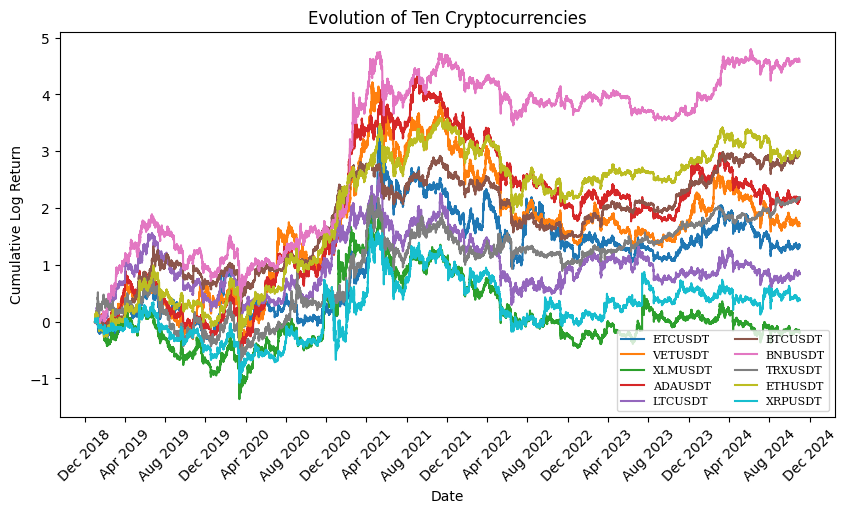

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 5))
tickers = all_data.index.get_level_values(0).unique()

# Randomly select 10 tickers if you want a subset
selected_tickers = np.random.choice(tickers, size=10, replace=False)

for ticker in selected_tickers:
	plt.plot(all_data.loc[ticker].index, 
             np.cumsum(all_data.loc[ticker]["DailyLogReturn"]), 
             label=f'{ticker}')
plt.title("Evolution of Ten Cryptocurrencies")
plt.xlabel('Date')
plt.gca().tick_params(axis='x', rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel('Cumulative Log Return')
plt.legend(ncol=2, loc="lower right", prop={'size': 8, 'family': 'serif'})
plt.show()

# Correlation between Cryptocurrency

Computing the correlation between currencies to initialise the edges for the graph. Current method utilises a date range to compute correlation (2023-10-01 to 2024-10-01). Preferably, we would use fundamental information about each currency for correlation

In [26]:
df_close = all_data.copy()

# Reset the index to access the time column
df_close.reset_index(inplace=True)

df_close = df_close[["time", "Ticker", "close"]]
df_close["time"] = pd.to_datetime(df_close["time"])
df_close.set_index("time", inplace=True)

# Sort the DataFrame by index to ensure it is monotonic
df_close.sort_index(inplace=True)

df_close["close"] = np.log(df_close["close"])

# Filter for dates in 2024
df_close_filtered = df_close.loc['2024-01-01':'2024-10-01']

# Reset index to prepare for pivoting
df_close_filtered.reset_index(inplace=True)

# Create a pivot table to reshape the DataFrame
df_close_filtered = pd.pivot_table(
    df_close_filtered, values="close", columns="Ticker", index="time"
)

df_close_filtered

Ticker,ADAUSDT,BNBUSDT,BTCUSDT,ETCUSDT,ETHUSDT,LTCUSDT,TRXUSDT,VETUSDT,XLMUSDT,XRPUSDT
time,,,,,,,,,,
2024-01-01 00:00:00,-0.514332,5.750666,10.656676,3.087856,7.738710,4.291281,-2.222665,-3.363035,-2.046394,-0.484184
2024-01-01 01:00:00,-0.507000,5.753525,10.659928,3.096030,7.742280,4.295106,-2.223774,-3.358713,-2.042531,-0.480458
2024-01-01 02:00:00,-0.511659,5.739471,10.659166,3.088311,7.737625,4.292649,-2.227385,-3.359864,-2.047943,-0.485483
2024-01-01 03:00:00,-0.518186,5.733988,10.653263,3.080073,7.729212,4.285929,-2.233899,-3.373485,-2.052605,-0.489390
2024-01-01 04:00:00,-0.518690,5.733988,10.654903,3.075005,7.731733,4.284000,-2.239235,-3.377579,-2.058072,-0.491677
...,...,...,...,...,...,...,...,...,...,...
2024-10-01 19:00:00,-1.040721,6.307734,11.030946,2.912351,7.819520,4.153556,-1.872102,-3.780556,-2.364460,-0.493477
2024-10-01 20:00:00,-1.039872,6.298214,11.015493,2.907447,7.804570,4.142341,-1.872753,-3.776182,-2.364460,-0.499886
2024-10-01 21:00:00,-1.040438,6.309736,11.020954,2.913437,7.812718,4.153871,-1.871452,-3.776182,-2.362335,-0.507996


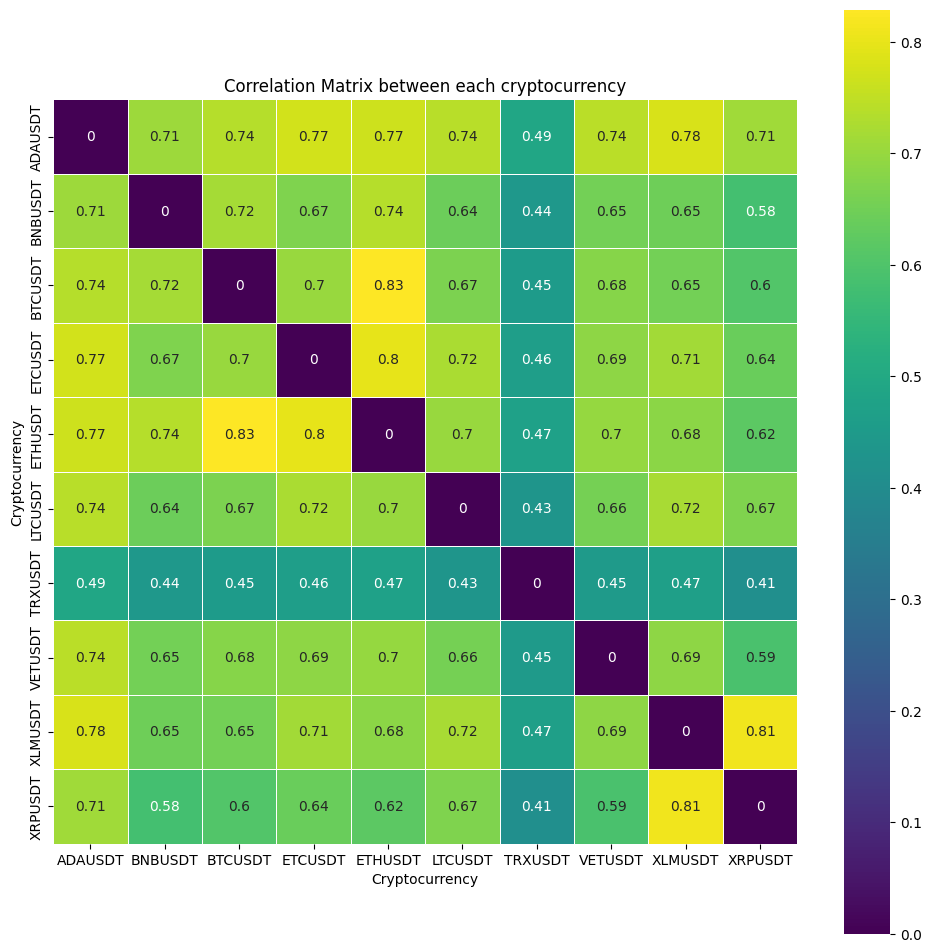

In [27]:
import seaborn as sns

correlation_matrix = df_close_filtered.diff().corr()
correlation_matrix = (correlation_matrix - (correlation_matrix == 1)) # Drop Self-Correlation

plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix,
            linewidths=.5,
            annot=True,
            square=True,
            cmap="viridis")
plt.xlabel("Cryptocurrency")
plt.ylabel("Cryptocurrency")
plt.title("Correlation Matrix between each cryptocurrency")
plt.show()

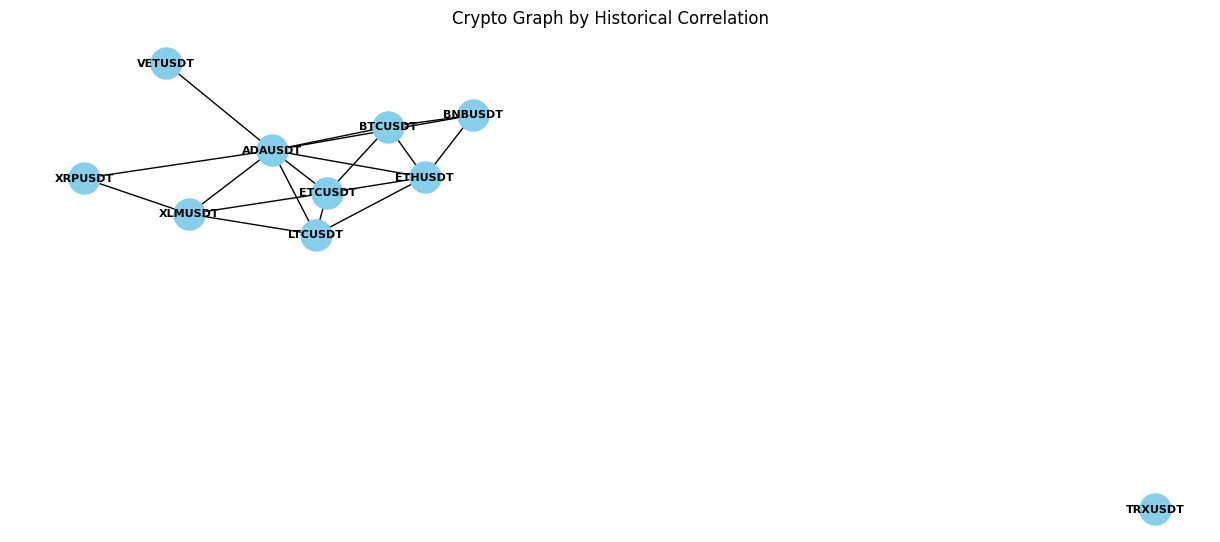

In [29]:
import networkx as nx

correlation_matrix_np = correlation_matrix.to_numpy()
adj_correlation_matrix = (correlation_matrix_np * (abs(correlation_matrix_np) > .7).astype(int)) # Threshold to form edge (0.7)

correlation_matrix_graph = nx.from_numpy_array(adj_correlation_matrix)
correlation_matrix_graph = nx.relabel_nodes(correlation_matrix_graph, dict(enumerate(correlation_matrix.index)))

plt.figure(figsize=(12, 5))
nx.draw(correlation_matrix_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(correlation_matrix_graph))
plt.title('Crypto Graph by Historical Correlation')
plt.show()

In [30]:
adj_correlation_matrix

array([[0.        , 0.70676245, 0.73776917, 0.77263774, 0.76557495,
        0.73917196, 0.        , 0.74281102, 0.77976407, 0.7109679 ],
       [0.70676245, 0.        , 0.71834042, 0.        , 0.73614959,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.73776917, 0.71834042, 0.        , 0.70101406, 0.82905795,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.77263774, 0.        , 0.70101406, 0.        , 0.7979908 ,
        0.72449322, 0.        , 0.        , 0.71391471, 0.        ],
       [0.76557495, 0.73614959, 0.82905795, 0.7979908 , 0.        ,
        0.70076141, 0.        , 0.        , 0.        , 0.        ],
       [0.73917196, 0.        , 0.        , 0.72449322, 0.70076141,
        0.        , 0.        , 0.        , 0.71903332, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.74281102, 0.        , 0.       

# Building PyTorch Geometric Dataset

In [15]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.8 MB/s eta 0:00:0000:0100:01


In [35]:
import torch
from torch_geometric.data import Data

nodes_nb = len(adj_correlation_matrix)
total_elements = all_data.shape[0] // nodes_nb
x = torch.tensor(
	all_data.drop(columns=["Ticker", "buy_base_vol", "volume", "buy_sell_quote_ratio", "close"]).to_numpy().reshape((nodes_nb, total_elements, all_data.shape[1] - 5)), dtype=torch.float32).to(device)  # shape (nodes_nb, timestamps_nb, features_nb) Note: This won't work if they are not integers
x = x.transpose(1, 2)  # shape (nodes_nb, features_nb, timestamps_nb)

close_prices = torch.tensor(
		all_data[["close"]].to_numpy().reshape((nodes_nb, -1)), dtype=torch.float32
	)

edge_nb = np.count_nonzero(adj_correlation_matrix)
edge_index, edge_weight = torch.zeros((2, edge_nb), dtype=torch.long).to(device), torch.zeros((edge_nb,), dtype=torch.float32).to(device)
count = 0
for i in range(nodes_nb):
		for j in range(nodes_nb):
			if (weight := adj_correlation_matrix[i, j]) != 0:
				edge_index[0, count], edge_index[1, count] = i, j
				edge_weight[count] = weight
				count += 1

x.shape, edge_index.shape, edge_weight.shape

ValueError: cannot reshape array of size 7148806 into shape (10,51062,14)

In [78]:
past_window, future_window = 25, 1
timestamps = [
			Data(
				x=x[:, :, idx:idx + past_window],
				edge_index=edge_index,
				edge_weight=edge_weight,
				close_price=close_prices[:, idx:idx + past_window],
				y=x[:, 0, idx + past_window:idx + past_window + future_window],
				close_price_y=close_prices[:, idx + past_window:idx + past_window + future_window],
			) for idx in range(x.shape[2] - past_window - future_window)
		]
print(timestamps[-1])

Data(x=[10, 14, 25], edge_index=[2, 36], y=[10, 1], edge_weight=[36], close_price=[10, 25], close_price_y=[10, 1])


# Model Definition

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv

class GCN(nn.Module):
	"""
	Simple two layers GCN model.
	"""
	def __init__(self, in_channels: int, layer_sizes: list[int] = None, bias: bool = True, improved: bool = False):
		super(GCN, self).__init__()
		layer_sizes = layer_sizes or [32, 32]
		self.convs = nn.ModuleList([
		   GCNConv(in_channels, layer_sizes[0], bias=bias, improved=improved),
		] + [
		   GCNConv(layer_sizes[i], layer_sizes[i + 1], bias=bias, improved=improved) for i in
		   range(len(layer_sizes) - 1)
   		])

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on the GCN model.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The hidden state of the GCN h_t (Nodes_nb, Hidden_size)
		"""
		for conv in self.convs[:-1]:
			x = F.leaky_relu(conv(x, edge_index, edge_weight))
		return self.convs[-1](x, edge_index, edge_weight)
        
class GAT(nn.Module):
	"""
	Simple two layers GCN model.
	"""
	def __init__(self, in_channels: int, layer_sizes: list[int] = None, bias: bool = True):
		super(GAT, self).__init__()
		layer_sizes = layer_sizes or [32, 32]
		self.convs = nn.ModuleList([
		   GATv2Conv(in_channels, layer_sizes[0], bias=bias, edge_dim=1),
		] + [
		   GATv2Conv(layer_sizes[i], layer_sizes[i + 1], bias=bias, edge_dim=1) for i in
		   range(len(layer_sizes) - 1)
   		])

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on the GCN model.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The hidden state of the GCN h_t (Nodes_nb, Hidden_size)
		"""
		for conv in self.convs[:-1]:
			x = F.leaky_relu(conv(x, edge_index, edge_weight))
		return self.convs[-1](x, edge_index, edge_weight)

class TGCNCell(nn.Module):
	"""
	T-GCN Cell for one timestep, from https://arxiv.org/pdf/1811.05320.
	"""
	def __init__(self, in_channels: int, hidden_size: int, use_gat: bool = True):
		super(TGCNCell, self).__init__()
		if use_gat:
			self.gcn = GAT(in_channels, [hidden_size, hidden_size])
		else:
			self.gcn = GCN(in_channels, [hidden_size, hidden_size])
		self.lin_u = nn.Linear(2 * hidden_size + in_channels, hidden_size)
		self.lin_r = nn.Linear(2 * hidden_size + in_channels, hidden_size)
		self.lin_c = nn.Linear(2 * hidden_size + in_channels, hidden_size)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor, h: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
		"""
		Performs a forward pass on a single T-GCN cell (GCN + GRU).
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:param h: The hidden state of the GRU h_{t-1} (Nodes_nb, Hidden_size)
		:return: The hidden state of the GRU h_t (Nodes_nb, Hidden_size)
		"""
		gcn_out = F.sigmoid(self.gcn(x, edge_index, edge_weight))  # f(A,X_t), Eq. 2
		u = F.sigmoid(self.lin_u(torch.cat([x, gcn_out, h], dim=-1)))  # u_t, Eq. 3
		r = F.sigmoid(self.lin_r(torch.cat([x, gcn_out, h], dim=-1)))  # r_t,  Eq. 4
		c = F.tanh(self.lin_c(torch.cat([x, gcn_out, r * h], dim=-1)))  # c_t, Eq. 5

		return u * h + (1 - u) * c  # h_t, Eq. 6

class TGCN(nn.Module):
	"""
	T-GCN model from https://arxiv.org/pdf/1811.05320.
	"""
	def __init__(self, in_channels: int, out_channels: int, hidden_size: int, layers_nb: int = 2, output_activation: nn.Module = None, use_gat: bool = True):
		super(TGCN, self).__init__()
		self.hidden_size = hidden_size
		self.layers_nb = max(1, layers_nb)
		self.cells = nn.ModuleList(
			[TGCNCell(in_channels, hidden_size, use_gat=use_gat)] + [TGCNCell(hidden_size, hidden_size, use_gat=use_gat) for _ in range(self.layers_nb - 1)]
		)
		self.out = nn.Sequential(
			nn.Linear(hidden_size, out_channels),
			output_activation if output_activation is not None else nn.Identity(),
		)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on the T-GCN model.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb, SeqLength)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The output of the model (Nodes_nb, OutFeatures_nb)
		"""
		h_prev = [
			torch.zeros(x.shape[0], self.hidden_size) for _ in range(self.layers_nb)
		]
		for t in range(x.shape[-1]):
			h = x[:, :, t]  # h is the output of the previous GRU layer (the input features for the first layer)
			for i, cell in enumerate(self.cells):
				h = cell(h, edge_index, edge_weight, h_prev[i])
				h_prev[i] = h
		return self.out(h_prev[-1])

class A3TGCN(nn.Module):
	"""
	A3T-GCN model from https://arxiv.org/pdf/2006.11583.
	"""
	def __init__(self, in_channels: int, out_channels: int, hidden_size: int, layers_nb: int = 2, output_activation: nn.Module = None, use_gat: bool = True):
		super(A3TGCN, self).__init__()
		self.hidden_size = hidden_size
		self.layers_nb = max(1, layers_nb)
		self.cells = nn.ModuleList(
			[TGCNCell(in_channels, hidden_size, use_gat=use_gat)] + [TGCNCell(hidden_size, hidden_size, use_gat=use_gat) for _ in range(self.layers_nb - 1)]
		)
		self.attention = nn.Sequential(
			nn.Linear(hidden_size, 1),
			nn.Softmax(dim=1),
		)
		nn.init.uniform_(self.attention[0].weight)
		self.out = nn.Sequential(
			nn.Linear(hidden_size, out_channels),
			output_activation if output_activation is not None else nn.Identity(),
		)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on the A3T-GCN model.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb, SeqLength)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The output of the model (Nodes_nb, OutFeatures_nb)
		"""
		h_prev = [
			torch.zeros(x.shape[0], self.hidden_size) for _ in range(self.layers_nb)
		]
		h_final = torch.zeros(x.shape[0], x.shape[-1], self.hidden_size)
		for t in range(x.shape[-1]):
			h = x[:, :, t]  # h is the output of the previous GRU layer (the input features for the first layer)
			for i, cell in enumerate(self.cells):
				h = cell(h, edge_index, edge_weight, h_prev[i])
				h_prev[i] = h
			h_final[:, t, :] = h
		return self.out(F.leaky_relu(torch.sum(F.leaky_relu(h_final) * self.attention(h_final), dim=1)))

# Training and Testing

In [79]:
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader

train_part = .9
batch_size = 32

train_dataset, test_dataset = timestamps[:int(train_part * len(timestamps))], timestamps[int(train_part * len(timestamps)):]
print(f"Train dataset: {len(train_dataset)}, Test dataset: {len(test_dataset)}")
train_dataloader, test_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=True)

Train dataset: 45915, Test dataset: 5102


In [80]:
in_channels, out_channels, hidden_size, layers_nb = timestamps[0].x.shape[-2], 1, 16, 2
#model = A3TGCN(in_channels, out_channels, hidden_size, layers_nb, use_gat=False)
# model = GAT(in_channels)
tgcn_model = TGCN(in_channels, out_channels, hidden_size, layers_nb, use_gat=True).to(device)

lr, weight_decay, num_epochs = 0.001, 1e-5, 16

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
model

TGCN(
  (cells): ModuleList(
    (0): TGCNCell(
      (gcn): GAT(
        (convs): ModuleList(
          (0): GATv2Conv(14, 16, heads=1)
          (1): GATv2Conv(16, 16, heads=1)
        )
      )
      (lin_u): Linear(in_features=46, out_features=16, bias=True)
      (lin_r): Linear(in_features=46, out_features=16, bias=True)
      (lin_c): Linear(in_features=46, out_features=16, bias=True)
    )
    (1): TGCNCell(
      (gcn): GAT(
        (convs): ModuleList(
          (0-1): 2 x GATv2Conv(16, 16, heads=1)
        )
      )
      (lin_u): Linear(in_features=48, out_features=16, bias=True)
      (lin_r): Linear(in_features=48, out_features=16, bias=True)
      (lin_c): Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Identity()
  )
)

In [14]:
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.data import DataLoader
from datetime import datetime
from tqdm import trange

def measure_accuracy(model: nn.Module, data: Data) -> float:
	"""
	Measure accuracy
	:param model: Model to test
	:param data: Data to test on
	:return: Accuracy
	"""
	out = model(data.x, data.edge_index, data.edge_weight)
	if out.shape[1] == 1:  # Binary classification
		return (F.sigmoid(out).round() == data.y).sum().item() / len(data.y)
	else:  # Multi-class classification
		return (F.softmax(out, dim=-1).argmax(dim=-1) == data.y).sum().item() / len(data.y)
        
def test_iteration(model: nn.Module, criterion: nn.Module, test_dataloader: DataLoader, epoch: int, writer: SummaryWriter, measure_acc: bool = False) -> None:
	"""
	Test iteration
	:param model: Model to test
	:param criterion: Loss function to use (MSE, CrossEntropy, ...)
	:param test_dataloader: Test data loader
	:param epoch: Current epoch
	:param writer: Tensorboard writer
	:param measure_acc: Whether to measure accuracy or not (for classification tasks)
	"""
	model.eval()
	for idx, data in enumerate(test_dataloader):
        data = data.to(device) 
		out = model(data.x, data.edge_index, data.edge_weight)
		loss = criterion(out, data.y)
		writer.add_scalar("Loss/Test Loss", loss.item(), epoch * len(test_dataloader) + idx)
		if measure_acc:
			acc = measure_accuracy(model, data)
			writer.add_scalar("Accuracy/Test Accuracy", acc, epoch * len(test_dataloader) + idx)


def train_iteration(model: nn.Module, optimizer: optim.Optimizer, pbar: trange, criterion: nn.Module, train_dataloader: DataLoader, epoch: int, writer: SummaryWriter, measure_acc: bool = False) -> None:
	"""
	Train iteration
	:param model: Model to train
	:param optimizer: Optimizer to use (Adam, ...)
	:param pbar: tqdm progress bar
	:param criterion: Loss function to use (MSE, CrossEntropy, ...)
	:param train_dataloader: Train data loader
	:param epoch: Current epoch
	:param writer: Tensorboard writer
	:param measure_acc: Whether to measure accuracy or not (for classification tasks)
	"""
	model.train()
	for idx, data in enumerate(train_dataloader):
        data = data.to(device) 
		optimizer.zero_grad()
		out = model(data.x, data.edge_index, data.edge_weight)
		loss = criterion(out, data.y)
		loss.backward()
		optimizer.step()
		pbar.set_postfix({"Batch": f"{(idx + 1) / len(train_dataloader) * 100:.1f}%"})
		writer.add_scalar("Loss/Train Loss", loss.item(), epoch * len(train_dataloader) + idx)
		if measure_acc:
			acc = measure_accuracy(model, data)
			writer.add_scalar("Accuracy/Train Accuracy", acc, epoch * len(train_dataloader) + idx)

def train(model: nn.Module, optimizer: optim.Optimizer, criterion: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, num_epochs: int, task_title: str = "", measure_acc: bool = False) -> None:
	"""
	Train function for a regression / classification model
	:param model: Model to train
	:param optimizer: Optimizer to use (Adam, ...)
	:param criterion: Loss function to use (MSE, CrossEntropy, ...)
	:param train_dataloader: Train data loader
	:param test_dataloader: Test data loader
	:param num_epochs: Number of epochs to train on the train dataset
	:param task_title: Title of the tensorboard run
	:param measure_acc: Whether to measure accuracy or not (for classification tasks)
	"""
	writer = SummaryWriter(f'runs/{task_title}_{datetime.now().strftime("%d_%m_%Hh%M")}_{model.__class__.__name__}')
	for epoch in (pbar := trange(num_epochs, desc="Epochs")):
		train_iteration(model, optimizer, pbar, criterion, train_dataloader, epoch, writer, measure_acc)
		test_iteration(model, criterion, test_dataloader, epoch, writer, measure_acc)

In [81]:
train(tgcn_model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs, "PriceForecasting")

Epochs:  69%|██████▉   | 11/16 [1:20:28<33:19, 399.95s/it, Batch=99.2%] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epochs: 100%|██████████| 16/16 [1:47:33<00:00, 403.33s/it, Batch=100.0%]


In [ ]:
model2 = A3TGCN(in_channels, out_channels, hidden_size, layers_nb, use_gat = True).to(device)

# Results

Printing Regression Error and plotting predictions against actual targets for comparison

In [115]:
from torch.nn import functional as F

def get_regression_error(model: nn.Module, dataloader: DataLoader) -> tuple[float, float, float, float]:
	"""
	Computes regression errors
	:param model: Model to test
	:param dataloader: Dataloader to test on
	:return: Mean squared error, rooted mean squared error, mean absolute error, mean relative error
	"""
	mse = 0
	rmse = 0
	mae = 0
	mre = 0
	for data in dataloader:
		out = model(data.x, data.edge_index, data.edge_weight)
		mse += F.mse_loss(out, data.y).item()
		rmse += F.mse_loss(out, data.y).sqrt().item()
		mae += F.l1_loss(out, data.y).item()
		mre += (F.l1_loss(out, data.y) / data.y.abs().mean()).item()
	return mse / len(dataloader), rmse / len(dataloader), mae / len(dataloader), mre / len(dataloader)

def plot_regression_all(model: nn.Module, data: Data, title: str = None) -> None:
    """
    Plot graphs for all currencies in the regression model
    :param model: Model to test
    :param data: Data to test on
    :param title: Title of the plot
    """
    model.eval()
    out = model(data.x, data.edge_index, data.edge_weight)
    
    preds = out.reshape(len(data.ptr) - 1, -1)
    target = data.y.reshape(len(data.ptr) - 1, -1)

    num_currencies = preds.shape[1]
    fig, axs = plt.subplots((num_currencies + 1) // 2, 2, figsize=(15, num_currencies * 2.5))
    fig.suptitle(title)

    for idx in range(num_currencies):
        ax = axs[idx // 2, idx % 2]
        ax.plot(target[:, idx].detach().numpy(), label="Real")
        ax.plot(preds[:, idx].detach().numpy(), label="Predicted")
        ax.set_title(f"Currency {idx}")
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to include title
    plt.show()

In [83]:
mse, rmse, mae, mre = get_regression_error(model, train_dataloader)
print(f"Train MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

KeyboardInterrupt: 

In [84]:
mse, rmse, mae, mre = get_regression_error(model, test_dataloader)
print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

Test MSE: 383297152.0000, RMSE: 19577.9766, MAE: 6527.5322, MRE: 0.9700


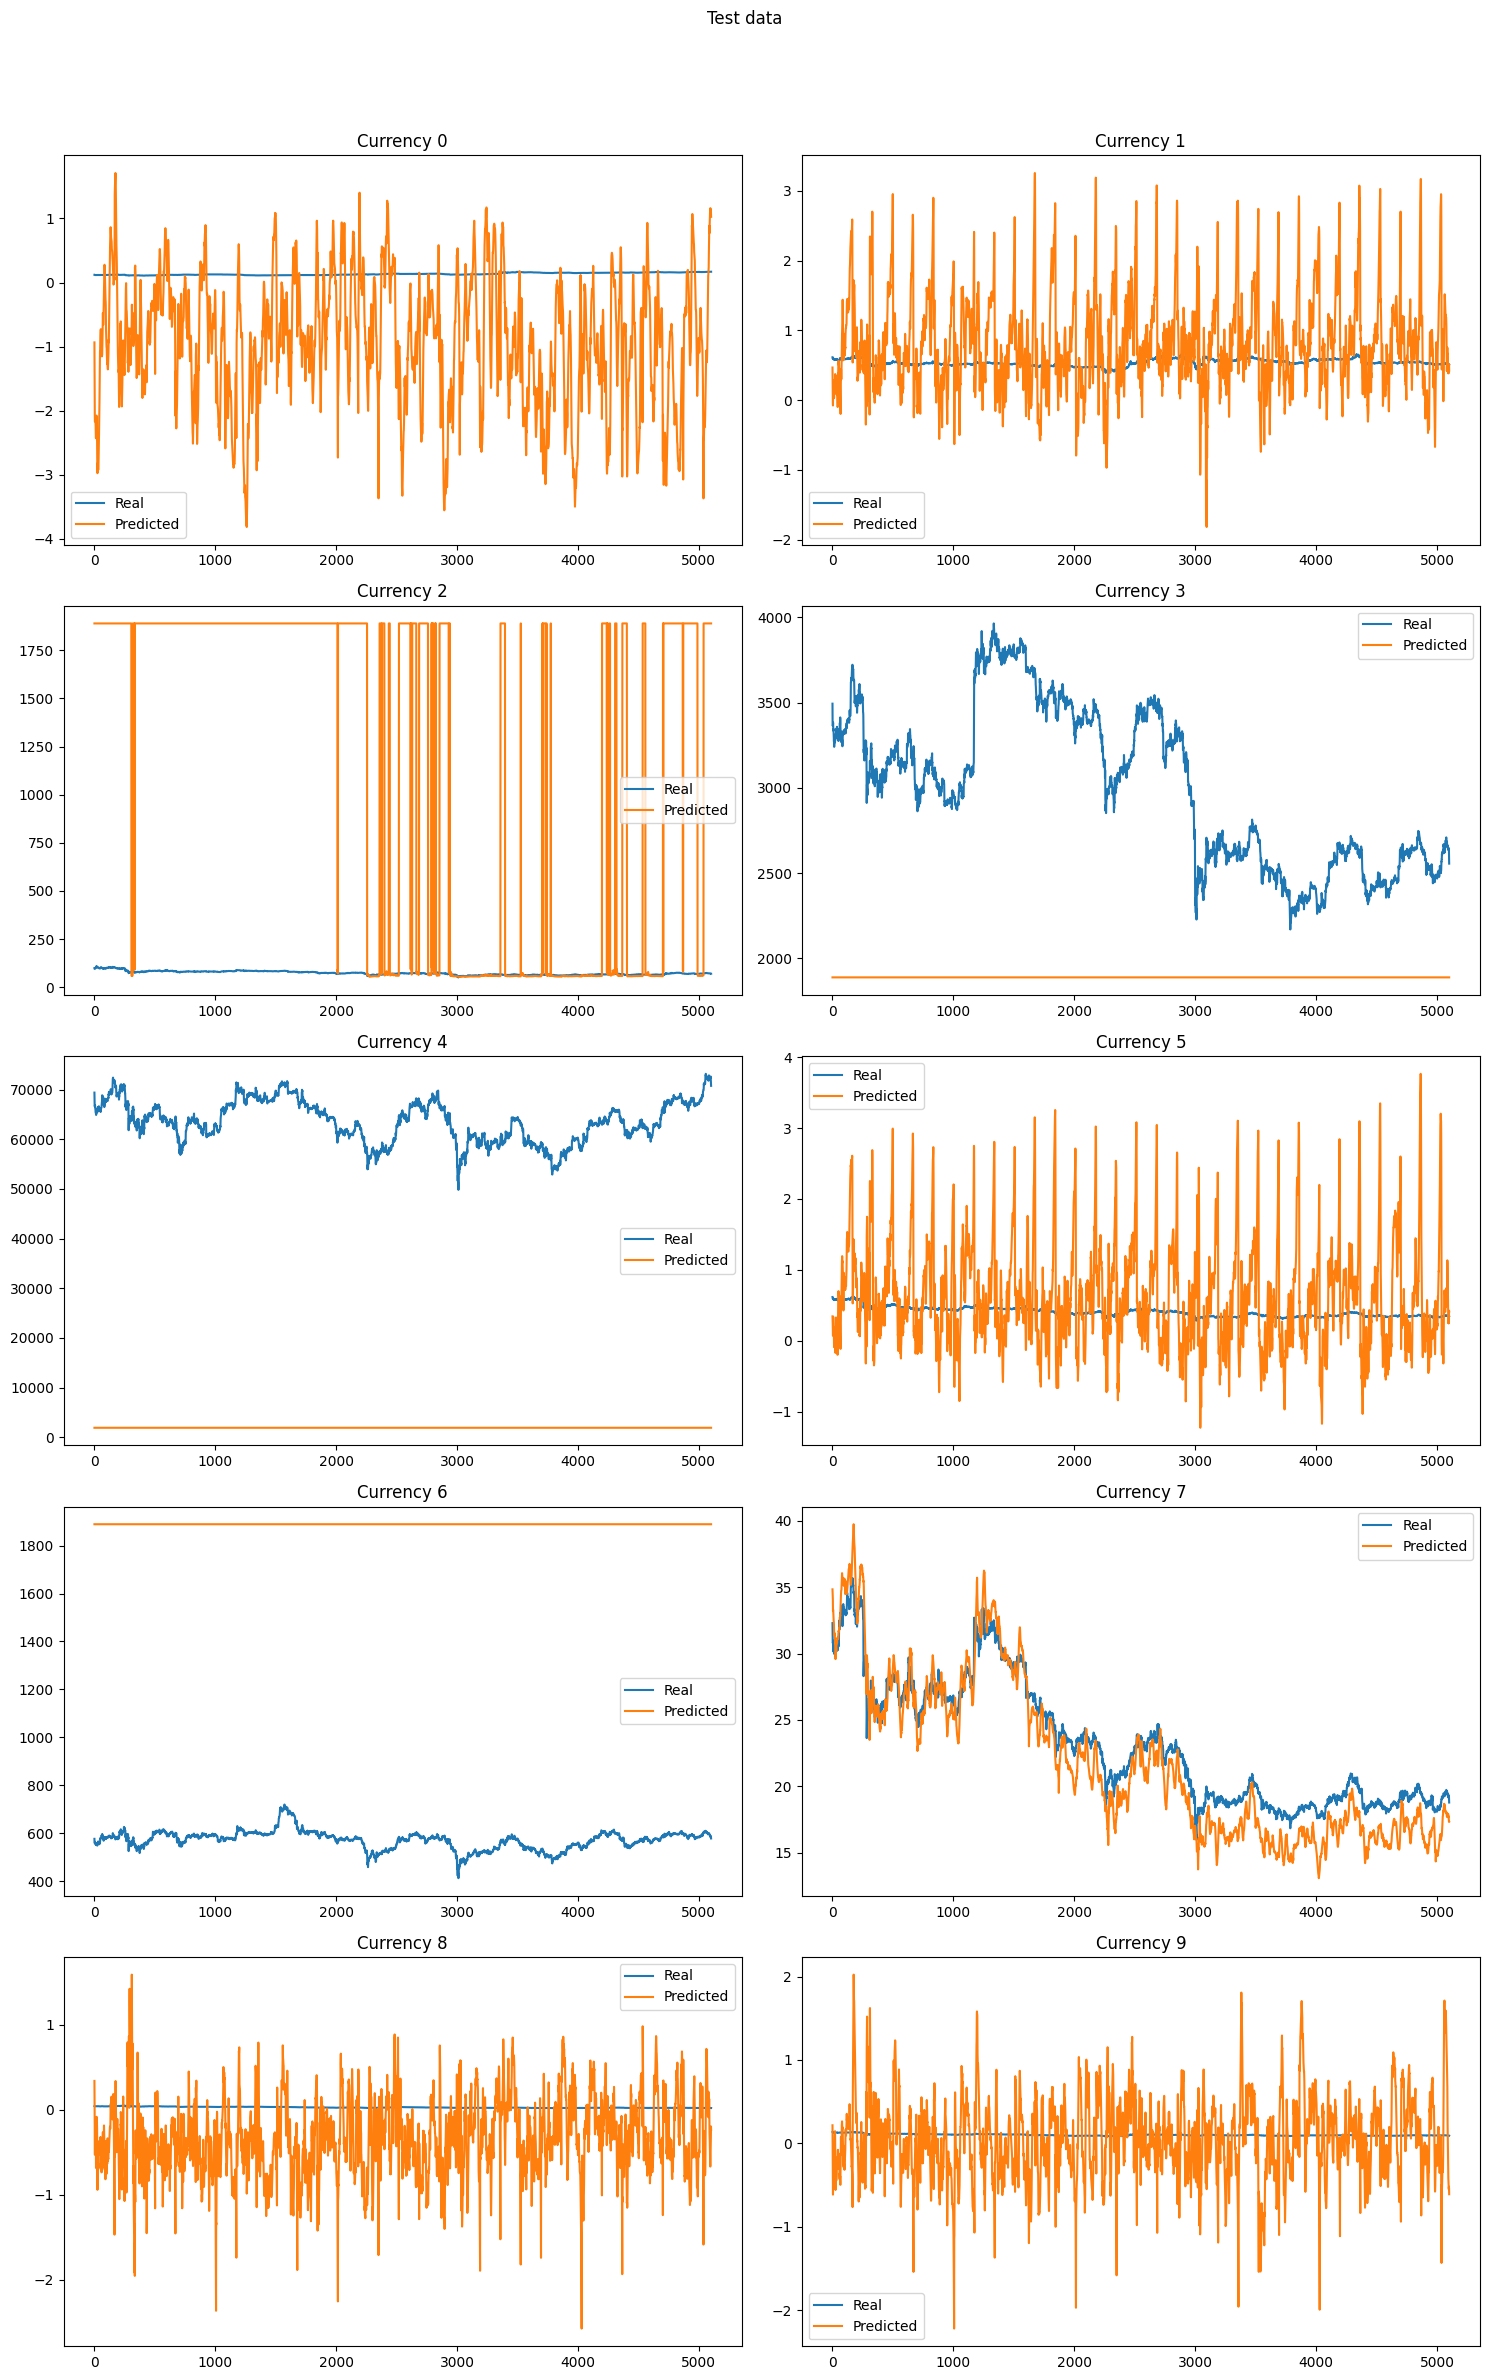

In [117]:
plot_regression_all(model, next(iter(test_dataloader)), "Test data")